In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For time stamps
from datetime import datetime

In [7]:
df = pd.read_csv('./data/all_stocks_5yr.csv')

In [8]:
top_10_companies_names = ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']
BAC = df[df['Name']=='BAC'].reset_index(drop=True)
AAPL = df[df['Name']=='AAPL'].reset_index(drop=True)
GE = df[df['Name']=='GE'].reset_index(drop=True)
F = df[df['Name']=='F'].reset_index(drop=True)
FB = df[df['Name']=='FB'].reset_index(drop=True)
MSFT = df[df['Name']=='MSFT'].reset_index(drop=True)
AMD = df[df['Name']=='AMD'].reset_index(drop=True)
MU = df[df['Name']=='MU'].reset_index(drop=True)
INTC = df[df['Name']=='INTC'].reset_index(drop=True)
CSCO = df[df['Name']=='CSCO'].reset_index(drop=True)
top_10_companies = [BAC, AAPL, GE, F, FB, MSFT, AMD, MU, INTC, CSCO] 

In [9]:
for c in top_10_companies:
    c.index = pd.to_datetime(c['date'])
    c.drop(columns=['Name'],inplace=True)

## Add return

In [10]:
for company in top_10_companies:
    company['return'] = company['close'] - company['open']

## Moving average for 3 7 and 30 days

In [11]:
ma_day = [4, 12, 52]

lag_feat = ['volume','high','low','return','open']
for feat in lag_feat:
    for ma in ma_day:
        for company in top_10_companies:
            column_name = f"{feat}_mean{ma}d"
            company[column_name] = company[feat].rolling(ma).mean().shift(1)
            column_name = f"{feat}_sd{ma}d"
            company[column_name] = company[feat].rolling(ma).std().shift(1)
            # company.reset_index()     

In [62]:
exog_feat = list(MSFT.columns[7:])

## SARIMA

In [25]:
series = GE['close']

In [26]:
log_close = np.log(series)
mean_log_close = log_close.rolling(12).mean()
mean_log_close.dropna(inplace=True)
diff = log_close - mean_log_close
diff.dropna(inplace=True)

<Figure size 640x480 with 0 Axes>

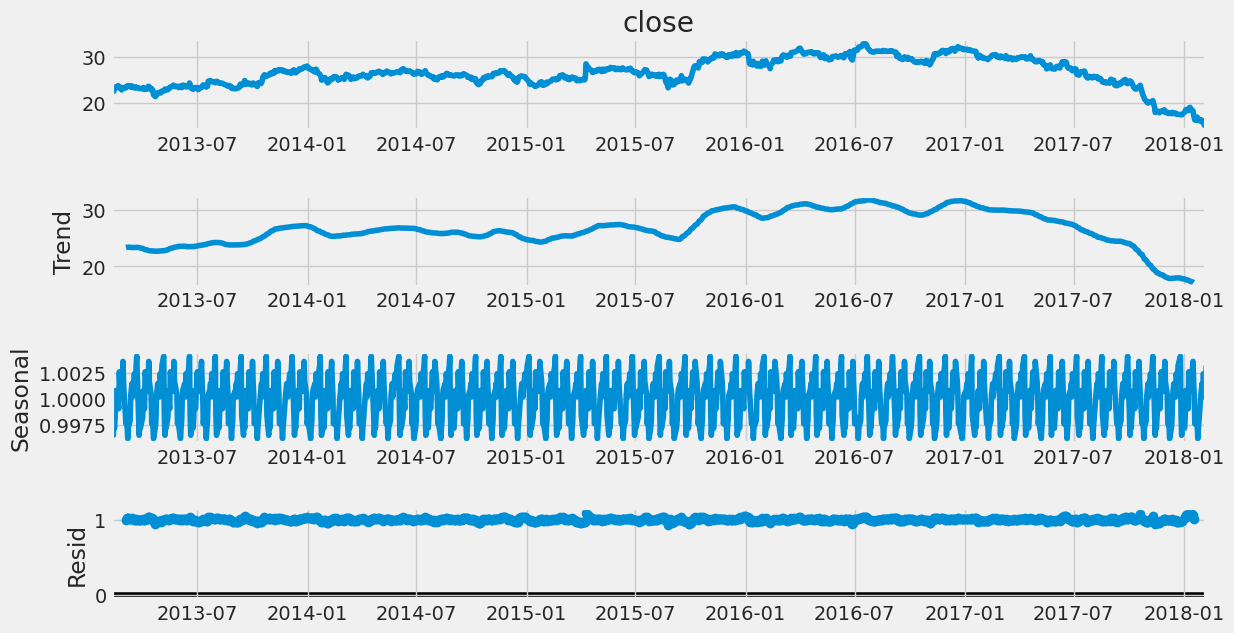

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series,model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 7)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

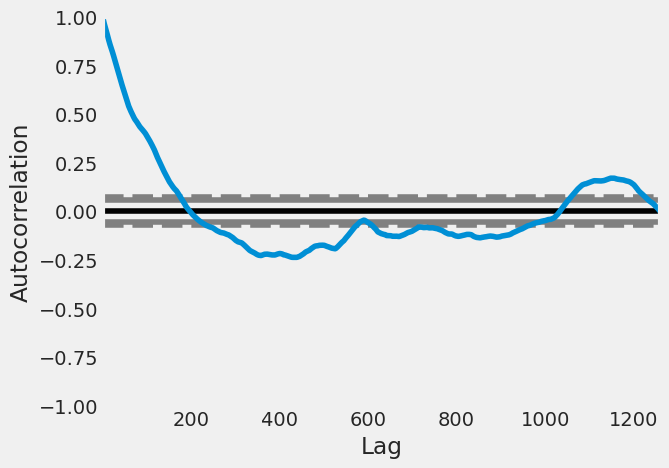

In [29]:
pd.plotting.autocorrelation_plot(series)

/home/jack/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


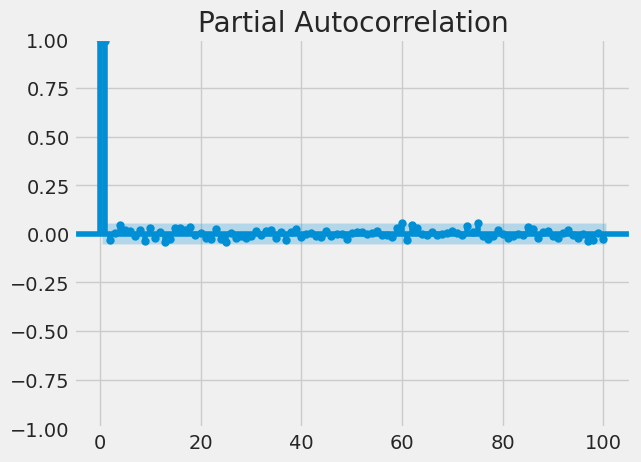

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(series, lags = 100)
plt.show()

In [35]:
p, d, q = 3, 1, 2
from statsmodels.tsa.arima.model import ARIMA

train_n = int(len(GE)*.75)


train,test = series[:train_n],series[train_n:]

model = ARIMA(train, order=(p,d,q))  
fitted = model.fit()  
print(fitted.summary())

/home/jack/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jack/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jack/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jack/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  944
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -208.851
Date:                Tue, 03 Jan 2023   AIC                            429.703
Time:                        15:14:29   BIC                            458.797
Sample:                             0   HQIC                           440.792
                                - 944                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5362      1.804      0.297      0.766      -3.000       4.072
ar.L2          0.1410      1.130      0.125      0.901      -2.073       2.355
ar.L3          0.0104      0.094      0.111      0.9

In [51]:
train = series[:int(len(series)*.8)]
test = series[int(len(series)*.8):]
# series.index = series.index.to_period('M')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
# model=SARIMAX(train,order=(p, d, q),seasonal_order=(p, d, q, 12))

model = SARIMAX(train, exog=None, order=(0, 1, 1), seasonal_order=(p, d, q, 12))
# model.fit(method='newton')
model.fit(method='lbfgs')

## Prophet

In [131]:
from prophet import Prophet
model = Prophet()

In [132]:
MSFT = MSFT.dropna()
train = MSFT[:int(len(MSFT)*.8)]
test = MSFT[int(len(MSFT)*.8):]

In [133]:
for f in exog_feat:
    model.add_regressor(f)

In [134]:
model.fit(train[["date", "close"] + exog_feat].rename(columns={"date": "ds", "close": "y"}))

16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing


In [142]:
forecast = model.predict(test[["date", "close"] + exog_feat].rename(columns={"date": "ds"}))
forecast.set_index('ds',inplace=True)

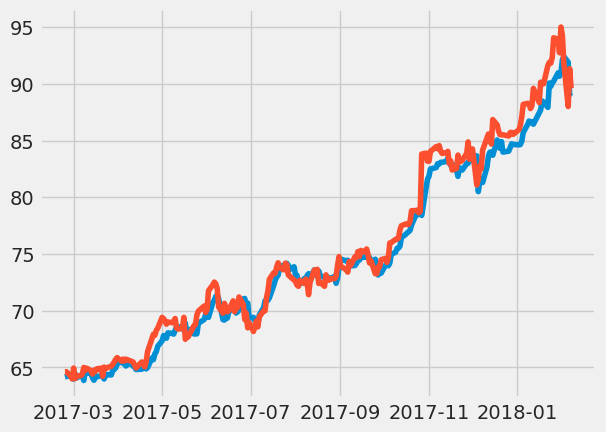

In [143]:
plt.plot(forecast['yhat'])
plt.plot(test['close'])

In [151]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mean_squared_error(forecast['yhat'],test['close'])**.5
mean_absolute_error(forecast['yhat'],test['close'])

0.9784741507368928

## LSTM

In [120]:
series = MSFT

In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat = exog_feat+['close']
GE[feat] = scaler.fit_transform(series[feat])

In [122]:
training_size = int(len(series)*.8)
train_data =  series[:training_size]
test_data  = series[training_size:]

In [123]:
import math

lag_n = 120

close_prices = series['close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(lag_n, len(train_data)):
    x_train.append(train_data[i-lag_n:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [125]:
test_data = scaled_data[training_data_len-lag_n: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(lag_n, len(test_data)):
    x_test.append(test_data[i-lag_n:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [148]:
import keras
from keras import layers

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 120, 100)          40800     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_7 (Dense)             (None, 25)                2525      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [153]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 100, epochs=3)

Epoch 1/3
9/9 [==============================] - 10s 715ms/step - loss: 3.0550e-04
Epoch 2/3
9/9 [==============================] - 7s 780ms/step - loss: 1.6283e-04
Epoch 3/3
9/9 [==============================] - 7s 755ms/step - loss: 1.3067e-04


In [159]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(rmse)
mae = np.mean(predictions - y_test)
print(mae)

[[0.5410829 ]
 [0.5483414 ]
 [0.5506806 ]
 [0.55818564]
 [0.55878216]
 [0.5571345 ]
 [0.5558501 ]
 [0.55647683]
 [0.5555718 ]
 [0.5539127 ]
 [0.5563714 ]
 [0.55778456]
 [0.55399996]
 [0.5496931 ]
 [0.5589156 ]
 [0.55332065]
 [0.55260026]
 [0.5531452 ]
 [0.5549462 ]
 [0.56198764]
 [0.5616572 ]
 [0.5625434 ]
 [0.5602453 ]
 [0.5558544 ]
 [0.55809766]
 [0.5585621 ]
 [0.5611707 ]
 [0.56285995]
 [0.5554126 ]
 [0.5610335 ]
 [0.5625259 ]
 [0.5637099 ]
 [0.56517345]
 [0.5675297 ]
 [0.57009685]
 [0.5732716 ]
 [0.57565856]
 [0.57266045]
 [0.5730059 ]
 [0.5716959 ]
 [0.57317185]
 [0.57357806]
 [0.5721134 ]
 [0.57106674]
 [0.56826615]
 [0.5644498 ]
 [0.5692522 ]
 [0.57088447]
 [0.5672314 ]
 [0.5704414 ]
 [0.5818275 ]
 [0.5980809 ]
 [0.606743  ]
 [0.60610026]
 [0.6085398 ]
 [0.6110196 ]
 [0.6219984 ]
 [0.62472045]
 [0.6219818 ]
 [0.6176224 ]
 [0.6187274 ]
 [0.61966336]
 [0.6216786 ]
 [0.62582403]
 [0.61809236]
 [0.6139601 ]
 [0.6141597 ]
 [0.62604994]
 [0.60960567]
 [0.6044361 ]
 [0.60431963]
 [0.61

/tmp/ipykernel_17498/2567670370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


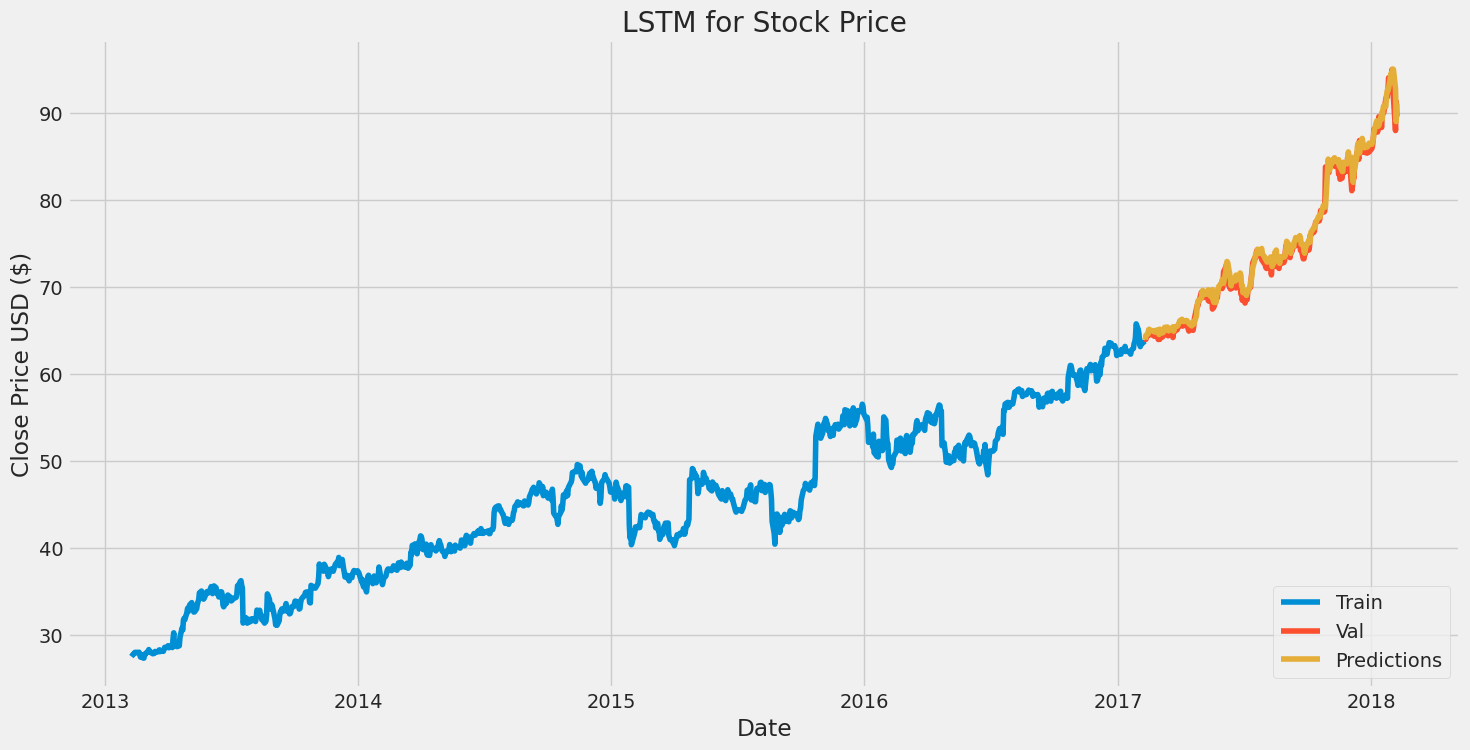

In [155]:
data = series.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM for Stock Price')¶¶
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Evaluation

### Microsoft
#### RMSE
- SARIMAX: N/A
- Prophet:1.279
- LSTM: 0.586
#### MAE
- SARIMAX
- Prophet:
- LSTM: 

#### Conclusion

LSTM demonstrates lowest error acrros the board, however is slower to train than the Prophet Model.